# Topic Modeling :: Kmeans Clustering Example

If you are using infomap's .ftree files, then follow the below process. 

If you already have edge data, then proceed to importing your tweet corpus and use the ```nttc.content_sampler()``` to produce your module-based samples. Be sure that your edge data are available in the following Dict format, where ```dict_full``` is merely an example variable name: 

- For a single period: 
```python
    dict_full = {
        'network':{
            '1': Module edges as DataFrame with 'source_name' and 'target_name' column names,
            '2': Module edges as DataFrame with 'source_name' and 'target_name' column names
        }
    }
```
- For multiple periods:
```python
    dict_full = {
        'network':{
            '1': {
                '1': Module edges as DataFrame with 'source_name' and 'target_name' column names,
                ...
            }
            '2': {
                '1': Module edges as DataFrame with 'source_name' and 'target_name' column names,
                ...
            },
            ...
        }
    }
```

In [1]:
import nttc
from os import listdir
from os.path import join
import csv
import pandas as pd
import matplotlib.pyplot as plt

# better viewing of tweet text
pd.set_option('display.max_colwidth', 150)

# reproducible rng
seed = 42

plt.style.use("bmh")
%matplotlib inline

## Import tweets

In [2]:
# Import cleaned and combined CSV data as pandas dataframe

data_path = '../collection/twint/full-combined'
encoded_data_path = '../data/encoded'
csv_header = 'id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,location,hashtags,link,retweet,quote_url,video'

# Define columns, as you need
dtype_dict={
    'id': str,
    'conversation_id': str,
    'username': str,
    'user_id': str,
    'mentions': str,
    'tweet': str,
    'hashtags': str,
    'link': str,
    'user_rt': str,
}

__encoded_all_file__ = 'cleaned-all-combined.csv'

df_all = pd.read_csv(join(encoded_data_path, __encoded_all_file__), 
                     delimiter=',',
                     dtype=dtype_dict)

df_all.describe()

/Users/chrisl/.pyenv/versions/3.6.2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,created_at,likes_count,location,replies_count,retweet,retweets_count,video
count,5.497620e+06,5.497620e+06,5.497619e+06,0.0,5.497619e+06,0.0,5.497619e+06,5.497387e+06
mean,4.538736e+06,1.687371e+12,1.183389e+01,NaN,1.123035e+00,NaN,5.045519e+00,1.407032e-02
std,2.373027e+06,3.460250e+14,7.989978e+02,NaN,7.224374e+01,NaN,2.640234e+02,1.177809e-01
min,0.000000e+00,1.514783e+12,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,2.706603e+06,1.530373e+12,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,4.542598e+06,1.545517e+12,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,6.571531e+06,1.547840e+12,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00
max,8.512494e+06,8.113264e+17,1.413747e+06,NaN,6.050200e+04,NaN,4.357410e+05,1.000000e+00


In [3]:
# Remove "Unnamed" column
del df_all['Unnamed: 0']
df_all[:2]

,conversation_id,created_at,date,hashtags,id,likes_count,link,location,mentions,name,...,replies_count,retweet,retweets_count,time,timezone,tweet,urls,user_id,username,video
0,1234556887654,3456787654562,2018-09-12,"['#hashtag1','#hashtag2']",1.0400116271968052e+18,0.0,https://twitter.com/username_example/status/12345678910,NaN,"['username1', 'username2', 'username3', 'username4']",Alex,...,0.0,NaN,0.0,18:57:49,EST,Example tweet text content for your enjoyment.,[],123456789,username_example,0


In [4]:
df_all["created_at"] = df_all["created_at"].astype(float)
df_all["created_at"] = df_all["created_at"].astype(int)
df_all['created_at'][:1]

0    1536793069000
Name: created_at, dtype: int64

In [5]:
# convert column "created_at" to datetime obj format; 'user_id' to string
df_all['user_id'] = df_all['user_id'].astype(str)
df_all['user_id'][:5]

0      1234567654
1      56787654456
2     9876567876543
3     3498573903495
4    54364576898876
Name: user_id, dtype: object

In [6]:
print(type(df_all['user_id'][0]))
print(type(df_all['created_at'][0]))

<class 'str'>
<class 'numpy.int64'>


## Create desired metadata as per your project: period dates and hashtag groups

In [7]:
# PERIOD DATES
ranges = [
    ('1', ['2018-01-01', '2018-03-30']),
    ('2', ['2018-04-01', '2018-06-12']),
    ('3', ['2018-06-13', '2018-07-28']),
    ('4', ['2018-07-29', '2018-10-17']),
    ('5', ['2018-10-18', '2018-11-24']),
    ('6', ['2018-11-25', '2018-12-10']),
    ('7', ['2018-12-11', '2018-12-19']),
    ('8', ['2018-12-20', '2018-12-25']),
    ('9', ['2018-12-26', '2019-02-13']),
    ('10', ['2019-02-14', '2019-02-28'])
]

period_dates = nttc.period_dates_writer(ranges=ranges)

# HASHTAG GROUPINGS
conservative_hashtag_list = [
    '#bordercrisis', '#bordersecurity', '#buildthewall',
    '#caravaninvasion', '#illegals',  '#migrantcaravan',
    '#nationalemergency', '#ronilsingh'
]

liberal_keyword_list = [ 
    {
        '#felipegomez': ['felipe alonzo-gomez', 'felipe gomez']
    },
    {
        '#maquin': ['jakelin caal', 'maquín', 'maquin' ]
    }
]
liberal_fbt_list = [
    '#familyseparation', '#familiesbelongtogether',
    '#felipegomez', '#keepfamiliestogether',
    '#maquin', '#noborderwall', '#wherearethechildren',
    'jakelin caal', 'maquín', 'maquin', 'felipe alonzo-gomez', 
    'felipe gomez'
]
liberal_antishutdown_list = [
    '#shutdownstories','#trumpshutdown'
]

period_dates['1'][:10]

['2018-01-01',
 '2018-01-02',
 '2018-01-03',
 '2018-01-04',
 '2018-01-05',
 '2018-01-06',
 '2018-01-07',
 '2018-01-08',
 '2018-01-09',
 '2018-01-10']

### 1. Sample from particular period, then detected community

#### 1.1 Import ftree module files

In [8]:
## Import .ftree files and process into respective network edge and node data per module

# 1. Retrieve directory of .ftree files and save each line of the file within a list of lists to per Period Dict
ftree_path = '../infomap/output/nets/ftree/ftree'

# regex is the file pattern in a dedicated directory, e.g., 
# # r"\d{1,2}" will match the '1' in p1_ftree.ftree
dict_map = nttc.batch_map(regex=r"\d{1,2}", path=ftree_path, file_type='ftree')

# Print sample ftree modules
print(
    '1.\nIndices: ',
    dict_map['1']['indices']['ftree_modules'],
    '\n\nFirst 5 file lines of module section: ',
    dict_map['1']['lines'][dict_map['1']['indices']['ftree_modules'][0]:5],
    '\n\n'
)

# Print sample ftree links
five = dict_map['1']['indices']['ftree_links']['1']['indices'][0]+5
print(
    '1.\nIndices for module 1 links: ',
    dict_map['1']['indices']['ftree_links']['1']['indices'],
    '\n\nFirst 5 lines of period 1, module 1 links section: ',
    dict_map['1']['lines'][dict_map['1']['indices']['ftree_links']['1']['indices'][0]:five],
    '\n\n'
)

1.
Indices:  [2, 50521] 

First 5 file lines of module section:  ['1:1 0.156246 "username1" 4', '1:2 0.138213 "username2" 294', '1:3 0.00534793 "username3" 533'] 


1.
Indices for module 1 links:  [50525, 95864] 

First 5 lines of period 1, module 1 links section:  ['2 1 0.00383033', '5 1 0.00319596', '1359 1 0.00299684', '1359 2 0.00298003', '28 1 0.0025742'] 




In [9]:
# Check output
dict_map['4']['indices']['ftree_links']['1']

{'exit_flow': '0.0',
 'indices': [43882, 71944],
 'num_children': '5602',
 'num_edges': '28062'}

### Process each period's module edge data and stores as a DataFrame.

In [10]:
copy_dict_map = dict_map
# Process each period's module edge data and stores as a DataFrame.
dict_with_edges = nttc.ftree_edge_maker(copy_dict_map)

Processing edge data for period 10
Processing edge data for period 1
Processing edge data for period 2
Processing edge data for period 3
Processing edge data for period 4
Processing edge data for period 5
Processing edge data for period 6
Processing edge data for period 7
Processing edge data for period 8
Processing edge data for period 9
Processing complete!


In [11]:
dict_with_edges['4']['indices']['ftree_links']['1']['df_edges'][:5]

,source,target,directed_count
0,30,1,0.00315307
1,7,1,0.00208902
2,31,1,0.00176528
3,23,2,0.00159538
4,32,1,0.00133167


### # Take full listified .ftree file and write per Period per Module hubs as a Dict

In [12]:
new_dict = dict_with_edges
# -1 retrieves entire module
dh = nttc.infomap_hub_maker(new_dict, file_type='ftree', mod_sample_size=10, hub_sample_size=-1)
print(
    '2.\nSample hub: ',
    dh['4']['info_hub']['2'][:5]
)

2.
Sample hub:  [{'node': '1', 'name': 'username1', 'score': 0.0514152}, {'node': '2', 'name': 'username2', 'score': 0.000577059}, {'node': '3', 'name': 'username3', 'score': 0.000184962}, {'node': '4', 'name': 'username4', 'score': 0.0001717}, {'node': '5', 'name': 'username5', 'score': 3.57708e-05}]


### Write edge and node lists per module: 

In [13]:
## Parameters: (Tuple period range, Tuple module range, Dict of module data from infomap_hub_maker)
## Below params only parse modules 1-10 in period 2
dict_full = nttc.networks_controller((2,3),(1,10),dh)

Processing period 1
Module 1


HBox(children=(IntProgress(value=0, max=45339), HTML(value='')))


Module 2


HBox(children=(IntProgress(value=0, max=6436), HTML(value='')))


Module 3


HBox(children=(IntProgress(value=0, max=2077), HTML(value='')))


Module 4


HBox(children=(IntProgress(value=0, max=1558), HTML(value='')))


Module 5


HBox(children=(IntProgress(value=0, max=750), HTML(value='')))


Module 6


HBox(children=(IntProgress(value=0, max=616), HTML(value='')))


Module 7


HBox(children=(IntProgress(value=0, max=205), HTML(value='')))


Module 8


HBox(children=(IntProgress(value=0, max=607), HTML(value='')))


Module 9


HBox(children=(IntProgress(value=0, max=284), HTML(value='')))


Module 10


HBox(children=(IntProgress(value=0, max=277), HTML(value='')))


Processing period 2
Module 1


HBox(children=(IntProgress(value=0, max=29491), HTML(value='')))


Module 2


HBox(children=(IntProgress(value=0, max=4839), HTML(value='')))


Module 3


HBox(children=(IntProgress(value=0, max=1241), HTML(value='')))


Module 4


HBox(children=(IntProgress(value=0, max=338), HTML(value='')))


Module 5


HBox(children=(IntProgress(value=0, max=224), HTML(value='')))


Module 6


HBox(children=(IntProgress(value=0, max=308), HTML(value='')))


Module 7


HBox(children=(IntProgress(value=0, max=427), HTML(value='')))


Module 8


HBox(children=(IntProgress(value=0, max=572), HTML(value='')))


Module 9


HBox(children=(IntProgress(value=0, max=128), HTML(value='')))


Module 10


HBox(children=(IntProgress(value=0, max=1002), HTML(value='')))


Processing period 3
Module 1


HBox(children=(IntProgress(value=0, max=64862), HTML(value='')))


Module 2


HBox(children=(IntProgress(value=0, max=7047), HTML(value='')))


Module 3


HBox(children=(IntProgress(value=0, max=2148), HTML(value='')))


Module 4


HBox(children=(IntProgress(value=0, max=1647), HTML(value='')))


Module 5


HBox(children=(IntProgress(value=0, max=1254), HTML(value='')))


Module 6


HBox(children=(IntProgress(value=0, max=776), HTML(value='')))


Module 7


HBox(children=(IntProgress(value=0, max=842), HTML(value='')))


Module 8


HBox(children=(IntProgress(value=0, max=1322), HTML(value='')))


Module 9


HBox(children=(IntProgress(value=0, max=617), HTML(value='')))


Module 10


HBox(children=(IntProgress(value=0, max=261), HTML(value='')))

In [14]:
dict_full['network']['3']['2']['edges'][:5]

,directed_count,source,source_name,target,target_name
0,0.00474017,2,username1,1,username2
1,0.00472335,3,username3,1,username2
2,0.00121372,15,username4,1,username2
3,0.00113362,108,username5,1,username2
4,0.000857446,4,username6,1,username2


## 2. Sample modules

In [15]:
# Reduce to as-needed columns
df_selected = df_all[['id', 'created_at', 'date', 'user_id', 'username', 'tweet', 'mentions', 'retweets_count', 'hashtags', 'link']]

In [16]:
dict_p = dict_full['network']['3']

#### SINGLE PERIOD

In [17]:
dict_samples = {}
dict_samples = nttc.content_sampler(
                    period_type='single',
                    network=dict_p, #Network Dict for period, since 'single'
                    sample_size=-1, # All available data
                    period_dates=period_dates, # Slices for period
                    corpus=df_selected, #Corpus to sample
                    sample_type='modules', 
                    ht_group=None,
                    user_threshold=5,
                    period_num='3',#DONT FORGET PERIOD NUMBER!!!
                    random=False)

Module 1 started.


HBox(children=(IntProgress(value=0, max=53021), HTML(value='')))


Module 1 sample size: 3472
Module 2 started.


HBox(children=(IntProgress(value=0, max=2164), HTML(value='')))


Module 2 sample size: 2914
Module 3 started.


HBox(children=(IntProgress(value=0, max=917), HTML(value='')))


Module 3 sample size: 1002
Module 4 started.


HBox(children=(IntProgress(value=0, max=1647), HTML(value='')))


Module 4 sample size: 25
Module 5 started.


HBox(children=(IntProgress(value=0, max=1058), HTML(value='')))


Module 5 sample size: 10
Module 6 started.


HBox(children=(IntProgress(value=0, max=776), HTML(value='')))


Module 6 sample size: 351
Module 7 started.


HBox(children=(IntProgress(value=0, max=842), HTML(value='')))


Module 7 sample size: 166
Module 8 started.


HBox(children=(IntProgress(value=0, max=791), HTML(value='')))


Module 8 sample size: 495
Module 9 started.


HBox(children=(IntProgress(value=0, max=201), HTML(value='')))


Module 9 sample size: 53
Module 10 started.


HBox(children=(IntProgress(value=0, max=261), HTML(value='')))


Module 10 sample size: 63


In [ ]:
def matcher(hts):
    for i in liberal_fbt_list:
        if i.lower() in hts.lower():
            return True
    else:
        return False

In [ ]:
# Use to query the sample data, if needed
# Noteworthy modules; 1,2,3,4,6,10
query = dict_samples['3']['sample']
query['ht_match'] = query['hashtags'].apply(matcher)
q = query[query['ht_match'] == True]
qq = q.drop_duplicates(subset=['id'], keep='first')

qq = qq[['username','tweet','retweets_count','hashtags','link','mentions','date','id','user_id']]

qq[:10].to_csv(join('../infomap/output/nets/ftree/csv', 'ftree_fbt_sample_extension_p4m3.csv'),
                                sep=',',
                                encoding='utf-8',
                                index=False)
qq[:10]

### 3. Plot tweets per week to see distribution

#### Reduce data set to what's needed

In [18]:
import itertools as it
from stop_words import get_stop_words

languages = ['english']
# collect and dedupe
stop_words = list(set(it.chain.from_iterable((get_stop_words(lang)
                                                for lang in languages))))
print('length of stopwords:', len(stop_words))

# look at a sample
print(stop_words[:10])

# ex: length-2 permutations of the given set of chars
[''.join(x) for x in it.product('#$.', repeat=2)]
stop_words = list(it.chain(stop_words, nttc.make_punc_stopwords(max_length=4)))

print('current count of stopwords: {}'.format(len(stop_words)))
print('example punctuation words:\n {}'.format(stop_words[-10:]))

length of stopwords: 174
['off', 'to', 'so', 'out', 'what', "don't", "we've", "you'll", "i've", 'there']
current count of stopwords: 1082575
example punctuation words:
 ['~~~[', '~~~\\', '~~~]', '~~~^', '~~~_', '~~~`', '~~~{', '~~~|', '~~~}', '~~~~']


In [19]:
columns_list = ['date','tweet','username']
dict_samples = nttc.sample_reducer('single', dict_samples, columns_list)

print('Lengths:\n',
    '1',len(dict_samples['1']['obj'].reduced_sample),
    '\n2',len(dict_samples['2']['obj'].reduced_sample),
    '\n3',len(dict_samples['3']['obj'].reduced_sample)
)

Lengths:
 1 3472 
2 2914 
3 1002


#### Convert dates to datetime object

In [65]:
dict_samples = nttc.df_datetime_converter('single', dict_samples, 'date')
dict_samples['2']['obj'].reduced_sample[:1]

/Users/chrisl/.pyenv/versions/3.6.2/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,date,tweet,username
0,2018-06-30,.@POTUS We The People Thank You for all you do for America 🇺🇸,rohll5


## Plot each module's tweet activity for the period

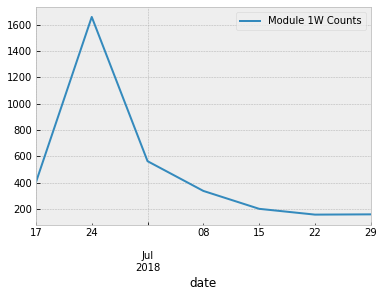

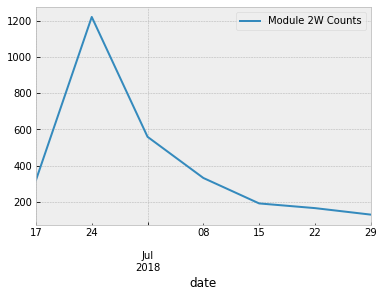

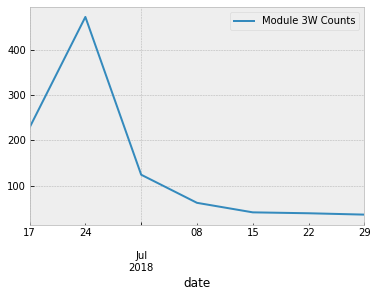

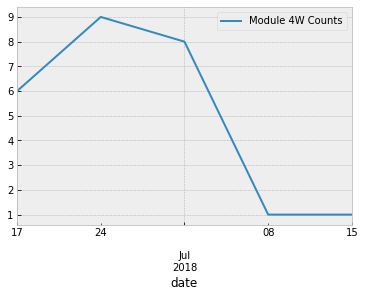

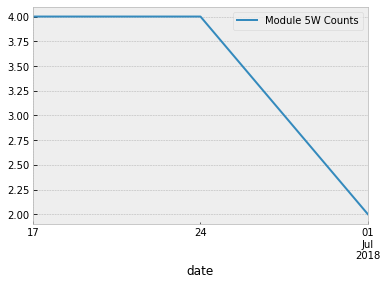

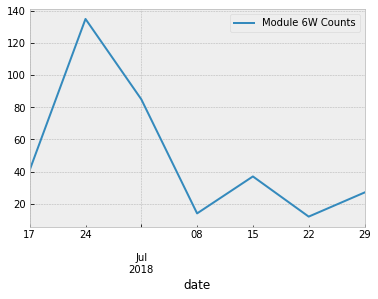

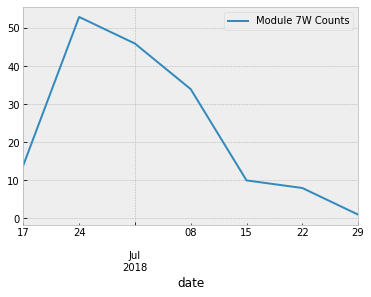

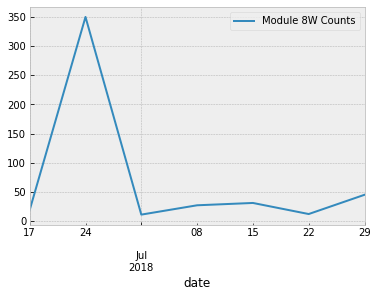

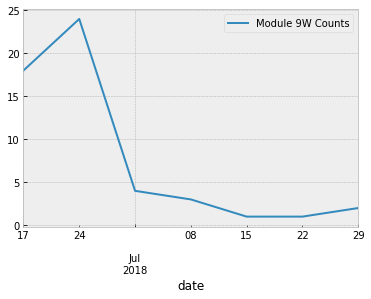

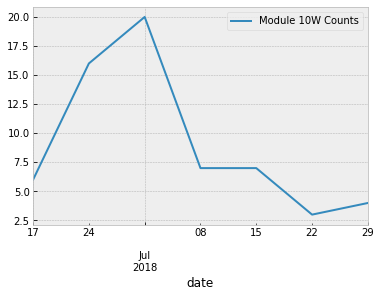

In [22]:
col_list = ['date','tweet']
nttc.plot_tweet_counts('single', dict_samples, 'W', col_list) #'W' == Weekly

## Tokenize community module tweets

In [30]:
dict_samples = nttc.tokenize_em('single', dict_samples, 'tweet')
dict_samples['1']['obj'].tokens[:5]

Total number of tokens: 99078
Total number of tokens: 89627
Total number of tokens: 29527
Total number of tokens: 581
Total number of tokens: 353
Total number of tokens: 9460
Total number of tokens: 4824
Total number of tokens: 13214
Total number of tokens: 1624
Total number of tokens: 2028


['just', 'left', 'border', 'patrol', 'processing']

In [31]:
# calculate a range of ngrams using some handy functions
dict_samples = nttc.top_gram_counter('single', dict_samples)
dict_samples = nttc.unique_obs_counter('single', dict_samples)

In [32]:
dict_samples['1']['obj'].top_grams

Counter({('just', 'left'): 2,
         ('left', 'border'): 2,
         ('border', 'patrol'): 9,
         ('patrol', 'processing'): 2,
         ('processing', 'center'): 2,
         ('center', 'in'): 2,
         ('in', 'mcallen'): 3,
         ('mcallen', '—'): 2,
         ('—', 'aka'): 2,
         ('aka', 'the'): 2,
         ('the', 'dog'): 2,
         ('dog', 'kennel'): 2,
         ('kennel', 'witnessed'): 2,
         ('witnessed', 'loads'): 2,
         ('loads', 'of'): 2,
         ('of', 'kids'): 11,
         ('kids', 'massed'): 2,
         ('massed', 'together'): 2,
         ('together', 'in'): 5,
         ('in', 'large'): 2,
         ('large', 'pens'): 2,
         ('pens', 'of'): 2,
         ('of', 'chain-linked'): 2,
         ('chain-linked', 'fence'): 2,
         ('fence', 'separated'): 2,
         ('separated', 'from'): 51,
         ('from', 'their'): 233,
         ('their', 'moms'): 2,
         ('moms', 'and'): 2,
         ('and', 'dads'): 2,
         ('dads', '@realdonaldtrump'

In [33]:
dict_samples['1']['obj'].unique_obs_cnt

2116

### Maintain the same ordering of users and tweets

#### Create one entry per user

In [34]:
# See the unique counts to gather a sense about which module's are worth analyzing
dict_samples = nttc.unique_observ_mapper('single', dict_samples, 'username', 'tweet')

1 2116 2116 2116
2 1964 1964 1964
3 605 605 605
4 18 18 18
5 9 9 9
6 302 302 302
7 130 130 130
8 398 398 398
9 37 37 37
10 38 38 38


#### Vectorizer

In [35]:
# Making vectors will automatically only take possible samples; anything else will error out
dict_samples = tm_vectorizer('single', dict_samples, stop_words)

Module 4 ValueError  max_features=0, neither a positive integer nor None Assign as None
Module 5 ValueError  max_features=0, neither a positive integer nor None Assign as None
Module 9 ValueError  max_features=0, neither a positive integer nor None Assign as None
Module 10 ValueError  max_features=0, neither a positive integer nor None Assign as None


### Calculate the data matrix

In [38]:
# From here, NTTC will filter out any cluster objects without vectors
dict_samples = nttc.calc_matrix('single', dict_samples)

In [39]:
dict_samples['1']['obj'].matrix

<2116x21 sparse matrix of type '<class 'numpy.float64'>'
	with 8633 stored elements in Compressed Sparse Row format>

In [66]:
# Print out sampled tweets, if desired, with the .u_texts property
print('* original tweet text *\n')
for i,tweet in enumerate(dict_samples['1']['obj'].u_texts[:3]):
    print(i,': ', tweet.replace('\n',' '))
    

* original tweet text *

0 :  Another example tweet #howcool
1 :  If this is a tweet, then I'm @potus.
2 :  It's a tweet, @username1. #hashtag  pic.twitter.com/example


In [42]:
# Print out sampled matrix, if desired, with the .matrix and .vector properties
(pd.DataFrame(dict_samples['1']['obj'].matrix[:10].todense(),
              columns=[x for x in dict_samples['1']['obj'].vector.get_feature_names()])
 # experiment by choosing any range of feature indices (alphabetical order)
 .iloc[:,0:10])

,ifd_example1,ifd_example2,ifd_example3,<-url->,ifd_example4,ifd_example5,ifd_example6,ifd_example7,ifd_example8,ifd_example9
0,0.000000,0.631543,0.000000,0.000000,0.273265,0.725589,0.00000,0.000000,0.000000,0.00000
1,0.000000,0.000000,0.000000,0.000000,0.154827,0.411104,0.00000,0.000000,0.378889,0.00000
2,0.000000,0.000000,0.529634,0.319186,0.191532,0.000000,0.00000,0.000000,0.000000,0.00000
3,0.505685,0.000000,0.000000,0.321354,0.192833,0.512022,0.00000,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.000000,0.857468,0.514537,0.000000,0.00000,0.000000,0.000000,0.00000
5,0.000000,0.231404,0.000000,0.000000,0.100127,0.000000,0.00000,0.000000,0.000000,0.54899
6,0.000000,0.000000,0.256513,0.154589,0.092763,0.000000,0.00000,0.292321,0.227009,0.00000
7,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000
8,0.611395,0.000000,0.000000,0.388532,0.233144,0.000000,0.00000,0.000000,0.000000,0.00000
9,0.000000,0.000000,0.000000,0.000000,0.293889,0.000000,0.69681,0.000000,0.000000,0.00000


## Selecting and Tuning a Model

Original text below modified from MIT-licensed [Twitter Dev "Do more with Twitter data"](https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html#selecting-and-tuning-a-model).

### KMeans

[KMeans](http://scikit-learn.org/stable/modules/clustering.html#k-means) is a common choice because it is very fast for moderate amounts of data. Like most algorithms, KMeans has parameters that need to be chosen appropriately. In this case, that parameter is k, the number of clusters in our data.

In unsupervised learning, we can’t easily calculate (and optimize) an accuracy score, so we have to use other techniques to compare models to one another for selecting k. Since we don’t know this number a priori, one technique involves comparing the value of some quality metric across a range of potential ks. There are a number of [known quality metrics](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), of which we’ll use just a couple: [silhouette score](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) (larger is better) and inertia (smaller is better).

We typically want to survey a wide, course range of ```k``` values, and then possibly narrow in to evaluate a smaller range around the best identified. The aforementioned metrics are an initial step to help choose a good ```k``` value. These metrics will rarely tell you the best answer for how many clusters are appropriate. Both of these plotted metrics will asymptotically approach their “ideal” value, and so the practitioner is typically advised to choose the value in “[the elbow](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method)” of these curves - that is, the point at which the returns seem to be diminishing for an increase in ```k```.

With the nttc ```.compare_kmeans()``` function below, you can quickly visualize an array of coarse values to identify a possible "elbow" to then identify and choose a best ```k``` value.

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

fitting model for 2 clusters
fitting model for 132 clusters
fitting model for 211 clusters
fitting model for 352 clusters
fitting model for 1058 clusters



HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

fitting model for 2 clusters
fitting model for 122 clusters
fitting model for 196 clusters
fitting model for 327 clusters
fitting model for 982 clusters



HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

fitting model for 2 clusters
fitting model for 37 clusters
fitting model for 60 clusters
fitting model for 100 clusters
fitting model for 302 clusters



HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

fitting model for 2 clusters
fitting model for 18 clusters
fitting model for 30 clusters
fitting model for 50 clusters
fitting model for 151 clusters



HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

fitting model for 2 clusters
fitting model for 8 clusters
fitting model for 13 clusters
fitting model for 21 clusters
fitting model for 65 clusters



HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

fitting model for 2 clusters
fitting model for 24 clusters
fitting model for 39 clusters
fitting model for 66 clusters
fitting model for 199 clusters



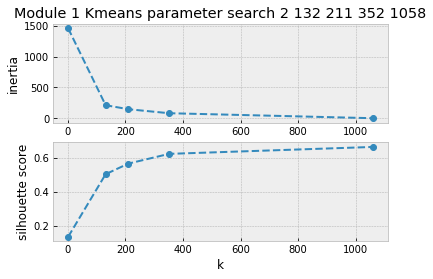

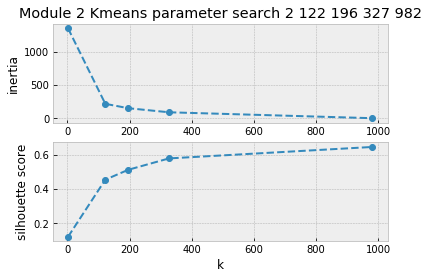

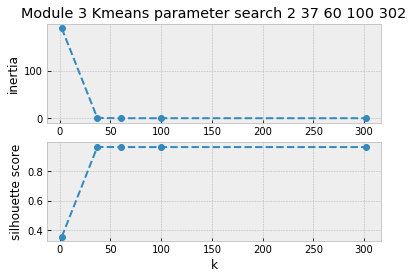

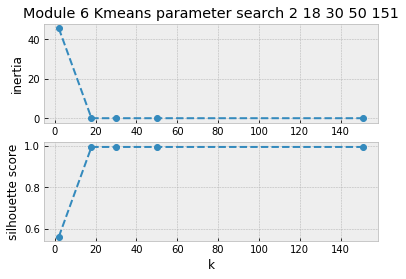

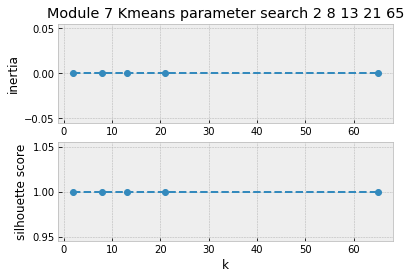

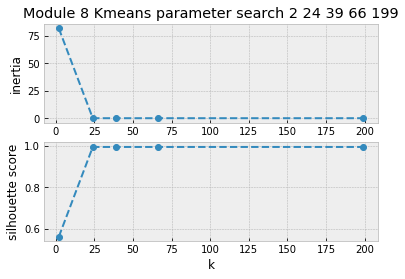

In [43]:
nttc.compare_kmeans('single', dict_samples, seed)

Based on the above outputs, consider the best ```k``` to begin with. To be a bit more careful, consider running the same comparison over a narrower range of k values. Furthermore, consider and incorporate other external constraints on your model. Maybe the number of user clusters according to the elbow is too many (or too few) to reasonably consider given the question you’re trying to answer with the data. Or, if you're trying to merely identify potential patterns to help you decide where and who to place your energy for qualitative analysis, OR to name the module for future analyses, use your judgement to decide the best value. Seek counsel, if you are unsure.

For now, log your best k value using the below method. Then, train a new model on all of our data, and carry on with the analysis.

In [44]:
from sklearn.cluster import KMeans
# Based on 'the elbows' visualized above, choose your best_k and write in Dict to assign individually
best_k_list = {'1':132,'2':122,'3':37,'6':18,'7':2,'8':24}

# Loop thru above Dict, and assign best_k
for m in dict_samples:
    if dict_samples[m]['obj'].vector is not None:
        dict_samples[m]['obj'].best_k = best_k_list[m]
        dict_samples[m]['obj'].km_model = KMeans(
                                                n_clusters=best_k_list[m], 
                                                n_jobs=-1, 
                                                random_state=seed)
        dict_samples[m]['obj'].km_model.fit(dict_samples[m]['obj'].matrix)
        
dict_samples['1']['obj'].km_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=132, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

### Inspecting model results

At this point, the trained model of tweets per module has clustered tweets along the assumptions enacted by the inverse document frequency (IDF) method. We can inspect the clusters to examine the modeled patterns, which can help examine the quality of the model and help qualitative researchers make decisions about how to proceed.

#### Population sizes

By checking the population of each cluster, you can compare and contrast the distributions. By doing so, you can perhaps use your existing knowledge about the corpus to help tease out unexpected or interesting results.

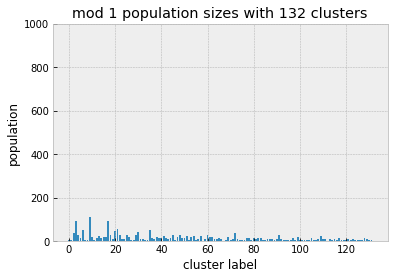

In [46]:
import numpy as np
plt.bar(range(len(set(dict_samples['1']['obj'].km_model.labels_))), np.bincount(dict_samples['1']['obj'].km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('mod 1 population sizes with {} clusters'.format(best_k_list['1']));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);

In [47]:
# Function originally from Twitter Dev: https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html#selecting-and-tuning-a-model
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    elif m_name is 'HDBSCAN':
        # ignore noise labels
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        for this_label in relevant_labels:
            matching_rows = np.where(hdbs.labels_ == this_label)[0]
            coeff_sums = np.sum(bio_matrix[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(features[idx]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans and HDBSCAN models')

In [48]:
strongest_features(dict_samples['1']['obj'].km_model, dict_samples['1']['obj'].vector, topk=15)

Cluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be liste

Cluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be listed here nCluster [num]: Example words from cluster will be liste

In [49]:
file_primer = 'clustering/tweet_matrix'+'3'#adding period number, since not parsed
dict_samples = nttc.fit_filename_writer('single', dict_samples, file_primer)
dict_samples['1']['obj'].fit_file

'clustering/tweet_matrix31_2d.npy'

In [56]:
dict_samples = nttc.trial_fit_tsne('single', dict_samples, 2000)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [57]:
dict_samples['1']['obj'].km_model.labels_

array([  6, 108,  25, ...,  83,  51,  72], dtype=int32)

In [58]:
# Check fits; If some don't fit, change the randomized seed param in trial_fit_tsne().
# Be sure to consider that change in relationship to your goals with these models
for m in dict_samples:
    if dict_samples[m]['obj'].vector is not None:
        print(
            len(dict_samples[m]['obj'].u_users), 
            len(dict_samples[m]['obj'].u_texts), 
            len(dict_samples[m]['obj'].matrix_2d), 
            len(dict_samples[m]['obj'].km_model.labels_)
        )

2116 2116 2116 2116
1964 1964 1964 1964
605 605 605 605
302 302 302 302
130 130 130 130
398 398 398 398


In [59]:
dict_samples = nttc.get_plottable_controller('single', dict_samples)

In [60]:
dict_samples['1']['obj'].km_plottable.head()

,username,text,label,x_val,y_val,color
0,username1,Example tweet here,6,-17.865280,-13.848690,#db8357
1,usernam2,Example tweet here ...,108,5.496714,-1.309122,#d757db
2,username3,Example tweet here #hashtag pic.twitter.com/example,25,-17.056479,16.609867,#c1db57
3,username4,#hasher: blah blah blah ...,64,1.257154,26.158756,#57dbd7
4,another_user,"More examples, yo ...",38,5.361260,-27.744196,#73db57


In [61]:
# Function originally from Twitter Dev: https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook; output_notebook()
from bokeh.models import HoverTool

def plot_tsne(df, title='t-SNE plot'):
    # add our DataFrame as a ColumnDataSource for Bokeh
    plot_data = ColumnDataSource(df)
    # configure the chart
    tsne_plot = figure(title=title, plot_width=800, plot_height=700, tools=('pan, box_zoom, reset'))
    # add a hover tool to display words on roll-over
    tsne_plot.add_tools(
        HoverTool(tooltips = """<div style="width: 400px;">(@label)(@ @username) @text</div>""")
    )
    # draw the words as circles on the plot
    tsne_plot.circle('x_val', 'y_val',
                     source=plot_data,
                     color='color',
                     line_alpha=0.2,
                     fill_alpha=0.1,
                     size=7,
                     hover_line_color='black')
    # configure visual elements of the plot
    tsne_plot.title.text_font_size = '12pt'
    tsne_plot.xaxis.visible = False
    tsne_plot.yaxis.visible = False
    tsne_plot.grid.grid_line_color = None
    tsne_plot.outline_line_color = None
    return tsne_plot

Loading BokehJS ...

### Add cluster sample counts and percentages

Before plotting your modules, perhaps add a new column with the percentage of the clusters share of tweets to the total for the module. This can help you see how the modeled clusters do not always mean they represenet a significant proportion of the sampled tweets. 

This information can help provide some additional context, when naming the module, or considering which modules and their features to trace and qualitatively code further.

You can also combine these dataframes and export them as CSV files for later analysis.

In [ ]:
# Add new percentage ratios for sampled data for comparison
dict_samples['1']['obj'].km_plottable['cluster_counts'] = dict_samples['1']['obj'].km_plottable.groupby('label')['label'].transform('count')
dict_samples['1']['obj'].km_plottable['cluster_perc'] = (dict_samples['1']['obj'].km_plottable.groupby('label')['label'].transform(lambda l: (l / len(dict_samples['1']['obj'].km_plottable))*100))
dict_samples['1']['obj'].km_plottable[:10]

In [62]:
show(plot_tsne(dict_samples['1']['obj'].km_plottable,
               'Period 3, Module 1 :: t-sne projection of kmeans-clustered users ["(cluster #) tweet"]'))

In [64]:
# Modify the idx_of_interest to print out cluster samples
interest_idx = 2

nttc.cluster_sample(
    dict_samples['1']['obj'].u_texts, 
    dict_samples['1']['obj'].km_model, 
    interest_idx,
    preview=10
)

Example tweet here …

Example tweet here …

Example tweet here ...

Example tweet here …

Example tweet here …

Example tweet here …

Example tweet here …

Example tweet here …

Example tweet here …

Example tweet here …

Example tweet here …

Example tweet here …

( >>> Truncated preview of cluster sample <<< )
